# Tiling and batching a hyperspectral image for semantic segmentation

The purpose of this file is to demonstrate the following:
- Reading a hyperspectral file with annotations (.png and JSON file)
- Splitting and "tiling" the image into smaller subimages

There are multiple libraries / functions for extracting image patches:
- https://www.tensorflow.org/api_docs/python/tf/image/extract_patches ("native" TensorFlow)
- https://scikit-image.org/docs/0.9.x/api/skimage.util.html#view-as-windows
- https://pypi.org/project/patchify/ 

In [1]:
# Imports
import tensorflow as tf
import pathlib
import spectral
import skimage
import matplotlib.pyplot as plt
import numpy as np

# "Local import" from massimal repository (https://github.com/mh-skjelvareid/massimal)
import annotation, image_render, hyspec_io, misc


In [2]:
# Paths
json_gray = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/label_classes.json'
annotation_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/Test_SampleAnnotations'
hyspec_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC'

In [3]:
# Find paths to annotated images
ann_file_paths_str = misc.file_pattern_search(annotation_dir,'*.png')
ann_file_paths = [pathlib.Path(fn) for fn in ann_file_paths_str]
for p in ann_file_paths:
    print(p.name)

OlbergholmenS_Pika_L_16-Radiance From Raw Data-Georectify Airborne Datacube.png
OlbergholmenS_Pika_L_17-Radiance From Raw Data-Georectify Airborne Datacube.png


In [4]:
# Read annotation metadata file, show classes
class_dict = annotation.read_hasty_metadata(json_gray)
for class_name,class_ind in class_dict.items():
    print(f'{class_name}: {class_ind}')

Sand: 1
Gravel: 2
Mud: 3
Terrestrial: 4
Zostera marina - dominant: 5
Zostera marina - normal: 6
Zostera marina - sparse: 7
Zostera marina with turf algae: 8
Turf algae - dominant: 9
Turf algae - normal: 10
Turf algae - sparse: 11
Rockweed: 12
Rockweed with turf algae: 13
Fucus serratus: 14
Aegagropila (algae ball): 15
Mixed algae classes on soft substrate: 16
Saccharina latissima: 17


In [5]:
# Load example hyperspectral file
hyspec_file = pathlib.Path(hyspec_dir) / (ann_file_paths[1].stem + '.bip.hdr')
hyspec_image, wl, rgb_ind, metadata = hyspec_io.load_envi_image(hyspec_file)

In [13]:
# Load example annotation file
annotation_mask = skimage.io.imread(ann_file_paths[1])
annotation_mask[np.all(hyspec_image==0,axis=2)] = 0        # Don't include zero data

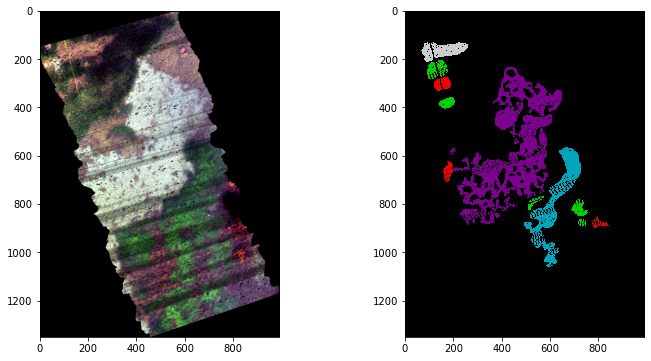

In [14]:
# Show image and annotation
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax[0].imshow(image_render.percentile_stretch(hyspec_image[:,:,rgb_ind]))
ax[1].imshow(annotation_mask,cmap='nipy_spectral',interpolation='none')
plt.show()

In [8]:
# Show classes present in annotation image
classes_present = list(np.unique(annotation_mask))
classes_present.remove(0)
class_dict_inv = {ind:cls_name for cls_name,ind in class_dict.items()}
print('Classes present in image:\n--------')
for cp in classes_present:
    print(class_dict_inv[cp])

Classes present in image:
--------
Sand
Zostera marina - dominant
Zostera marina with turf algae
Rockweed with turf algae
Aegagropila (algae ball)


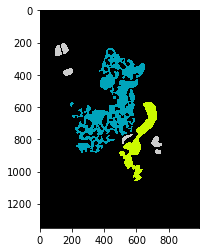

In [9]:
# Create new annotation mask and new class dict with subset of classes
subset_class_dict, subset_class_mask = annotation.extract_subset(
    class_dict,annotation_mask,['Sand','Zostera marina - dominant','Zostera marina with turf algae'])
plt.imshow(subset_class_mask,cmap='nipy_spectral',interpolation='none')
plt.show()

In [10]:
def labeled_image_to_tensor_tiles(image,labels,tile_shape,
                                  tile_strides=None,padding='SAME',
                                  include_unlabeled = False):
    """ Split image and label mask into smaller tiles
    
    # Usage:
    (image_tiles,label_tiles) = ...
    
    # Input arguments:
    image:        3D numpy array with dimensions (rows, columns, channels)
    labels:       2D numpy array with dimensions (rows,columns)
    tile_shape:   Tuple of integers, (tile_rows, tile_cols)
    
    # Keyword arguments
    tile_strides: Tuple of integers, (row_stride, col_stride)
                  If None, set equal to tile_shape (no overlap between tiles)
    padding:      'VALID' or 'SAME' (see tensorflow.image.extract_patches)
                  Default: 'SAME'
    include_unannotated
    """
    
    if tile_strides is None: tile_strides = tile_shape
    
    image_tensor = tf.reshape(tf.convert_to_tensor(image),(1,)+image.shape)
    label_tensor = tf.reshape(tf.convert_to_tensor(labels),(1,)+labels.shape + (1,))
    
    sizes = [1,*tile_shape,1]
    strides = [1,*tile_strides,1]
    rates = [1,1,1,1]
    
    image_tiles = tf.image.extract_patches(image_tensor, sizes, strides, rates, padding=padding)
    image_tiles = tf.reshape(image_tiles,[-1,*tile_shape,image.shape[-1]])
    label_tiles = tf.image.extract_patches(label_tensor, sizes, strides, rates, padding=padding)
    label_tiles = tf.reshape(label_tiles,[-1,*tile_shape])
    
    if not include_unlabeled:
        labeled_tiles_mask = np.array([not(tf.math.reduce_all(tile==0)) for tile in label_tiles])
        image_tiles = tf.boolean_mask(image_tiles,labeled_tiles_mask)
        label_tiles = tf.boolean_mask(label_tiles,labeled_tiles_mask)
        
    return image_tiles, label_tiles


In [11]:
# Extract tile from image
tile_shape = (128,128)
X_tiles, y_tiles = labeled_image_to_tensor_tiles(hyspec_image,subset_class_mask,tile_shape)
print(f'{X_tiles.shape=}, \n{y_tiles.shape=}')

2023-01-24 14:03:35.188280: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-01-24 14:03:35.188309: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mha114-ThinkPad-P52
2023-01-24 14:03:35.188315: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mha114-ThinkPad-P52
2023-01-24 14:03:35.188413: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-24 14:03:35.188432: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-24 14:03:35.188436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-01-24 14:03:35.192312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

X_tiles.shape=TensorShape([34, 128, 128, 173]), 
y_tiles.shape=TensorShape([34, 128, 128])


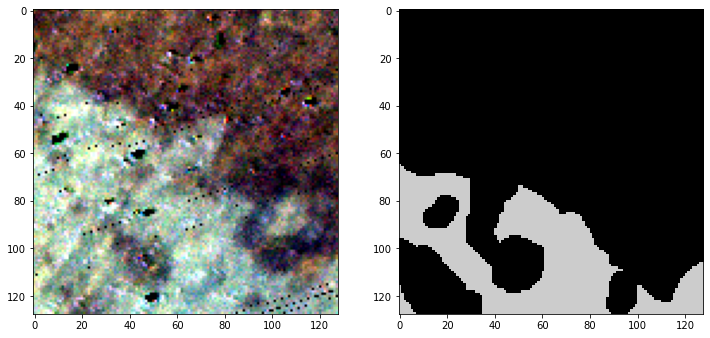

In [12]:
# Show an example tile with annotation
tile_ind = 5
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax[0].imshow(image_render.percentile_stretch(np.array(X_tiles[tile_ind])[:,:,rgb_ind]))
ax[1].imshow(np.array(y_tiles[tile_ind]),cmap='nipy_spectral',interpolation='none')
plt.show()